# MINIST CON LENET-5

In [86]:
import torch
import torchvision
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
torch.set_num_threads(8)
torch.set_num_interop_threads(8)

## CREACION DEL MODELO

In [87]:
#torchvision.models.
#LeNet-5
#modificado para inputs 28x28x1

def block(c_in,c_out,k=3,p=1,s=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in,c_out,k,padding=p,stride=s),
        torch.nn.Tanh(),
        torch.nn.AvgPool2d(2,stride=2)
    )
def block2(c_in,c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in,c_out),
        torch.nn.ReLU()
    )

class LeNet5(torch.nn.Module):
    def __init__(self,n_channels=1,n_outputs=10):
        super().__init__()
        self.conv1=block(n_channels,6,5,0)
        self.conv2 = block(6,16,5,0)
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16,120,3,padding=0),
            torch.nn.Tanh()
        )
        self.fc1 = block2(480,84)
        self.fc2 = torch.nn.Linear(84,10)

    def forward(self,x):
        x=self.conv1(x)
#        print(x.size())
        x=self.conv2(x)
#        print(x.size())
        x=self.conv3(x)
#        print(x.size())
        x=x.view(x.shape[0], -1)
#        print(x.size())
        x=self.fc1(x)
#        print(x.size())
        x=self.fc2(x)
#        print(x.size())
        return x

In [88]:
lenet5=LeNet5()
output=lenet5(torch.randn(64,1,28,28))
output.size()


torch.Size([64, 10])

## ENTRENAMIENTO

In [89]:
trainset = torchvision.datasets.MNIST(root="H:/Mi unidad/CORL/EjemploMNIST/finetuningmnist/data",train=True,download=True)
testset  = torchvision.datasets.MNIST(root="H:/Mi unidad/CORL/EjemploMNIST/finetuningmnist/data",train=False,download=True)

print(len(trainset))
print(len(testset))

print(trainset.data[0])

60000
10000
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 

In [90]:
train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [91]:
train_images.shape

(60000, 28, 28)

In [92]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().unsqueeze(1)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

### Una sola imagen

In [93]:
dataset = Dataset(train_images[:1], train_labels[:1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

print(len(dataset))

for x_b, y_b in dataloader:
    print(x_b.shape)
print(torch.randn(1,1,28,28).shape)

print(train_images[0].shape)
print(torch.from_numpy(train_images[0]).shape)

1
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
(28, 28)
torch.Size([28, 28])


In [94]:
epochs = 3
criterion = torch.nn.CrossEntropyLoss()
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")


Epoch 1/3 loss 2.29869 y 5 y_pred 6
Epoch 2/3 loss 1.70600 y 5 y_pred 5
Epoch 3/3 loss 0.03273 y 5 y_pred 5


### Un batch

In [95]:
dataset = Dataset(train_images[:64], train_labels[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

In [96]:
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1): 
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()  
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/100 loss 0.16416 acc 62/64
Epoch 20/100 loss 0.00070 acc 64/64
Epoch 30/100 loss 0.00002 acc 64/64
Epoch 40/100 loss 0.00001 acc 64/64
Epoch 50/100 loss 0.00001 acc 64/64
Epoch 60/100 loss 0.00000 acc 64/64
Epoch 70/100 loss 0.00000 acc 64/64
Epoch 80/100 loss 0.00000 acc 64/64
Epoch 90/100 loss 0.00000 acc 64/64
Epoch 100/100 loss 0.00000 acc 64/64


### Todo el conjunto de datos

In [97]:
dataset = {
    'train': Dataset(train_images, train_labels),
    'val': Dataset(test_images, test_labels),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}
len(dataset['train']), len(dataset['val'])

(60000, 10000)

In [98]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):

    model=torch.nn.parallel.DataParallel(model) #paralelizamos
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) #si hay gpu lo hacemos ahi


    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            x_b=x_b.to(device)
            y_b=y_b.to(device)
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [99]:
lrs = [0.01, 0.001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = LeNet5()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)
# 5 minutos

Probando lr 0.01
Probando lr 0.001


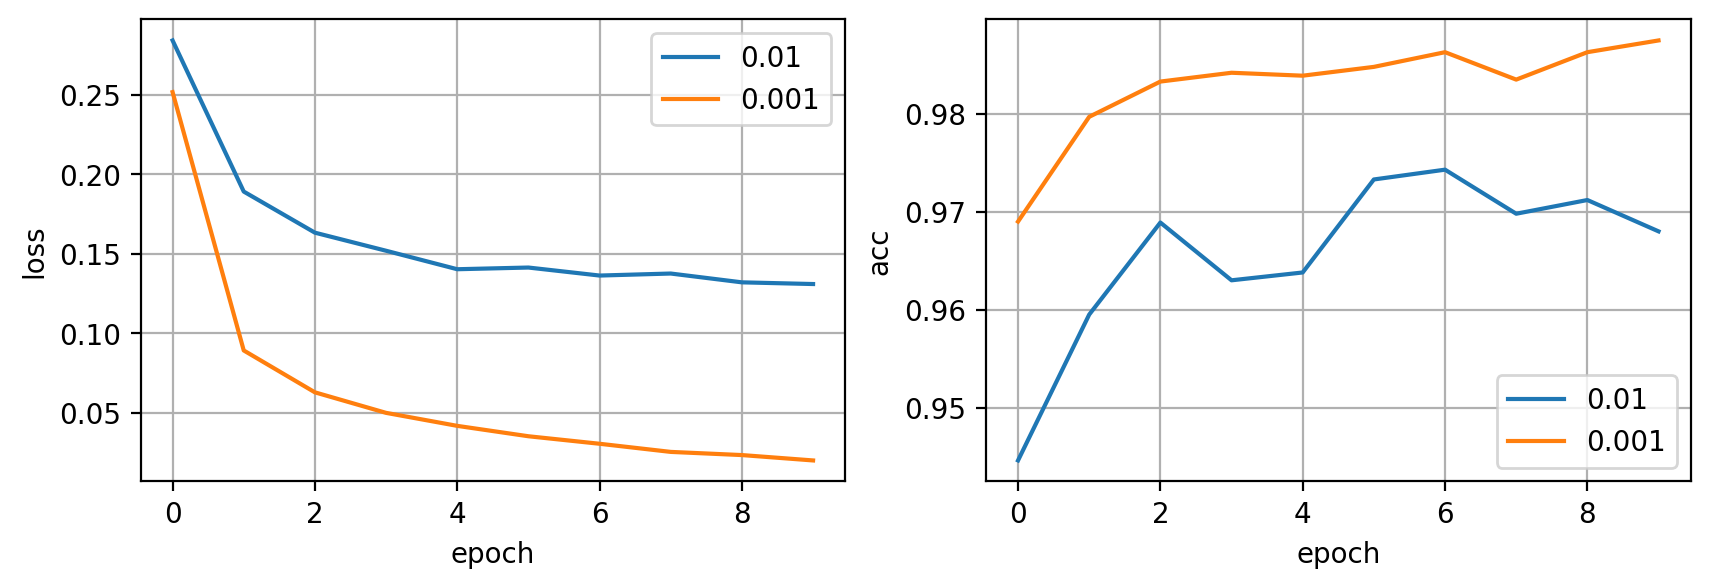

In [100]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()